<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week6/GRU_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GRU Model wit PyTorch 🏡: DeteksiSarkasme.json Dataset**

##Install Necessary Packages

In [1]:
!pip install torch torchvision torchaudio
!pip install sklearn matplotlib


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


##Import Required Libraries


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re


##Load and Preprocess the Data

In [7]:
# Load the dataset
data = pd.read_json('/content/Cleaned_DeteksiSarkasme.json')


In [8]:
# Tokenizer function
def tokenize(text):
    # Lowercase and remove special characters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text.split()


In [9]:
# Apply tokenization to the dataset
data['tokens'] = data['headline'].apply(tokenize)


In [10]:
# Prepare target variable (sarcasm label)
labels = LabelEncoder().fit_transform(data['is_sarcastic'])


In [11]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], labels, test_size=0.2, random_state=42)

In [12]:
# Create vocabulary from the training set
all_tokens = [token for sublist in data['tokens'] for token in sublist]
vocab = {word: idx + 1 for idx, (word, _) in enumerate(Counter(all_tokens).items())}  # Reserve 0 for padding


In [13]:
# Convert tokens to sequences of integers
def text_to_sequence(tokens, vocab, max_len=100):
    # Convert tokens to their corresponding integer ids in the vocab
    sequence = [vocab.get(token, 0) for token in tokens]  # Use 0 for unknown words
    # Pad the sequence to the max_len
    return sequence[:max_len] + [0] * (max_len - len(sequence))


In [14]:
# Apply text_to_sequence to the training and testing data
X_train_seq = X_train.apply(lambda tokens: text_to_sequence(tokens, vocab))
X_test_seq = X_test.apply(lambda tokens: text_to_sequence(tokens, vocab))

In [15]:
# Create a custom Dataset for PyTorch
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, max_len=100):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels[idx]
        text_tensor = torch.tensor(text)
        label_tensor = torch.tensor(label).float()
        return text_tensor, label_tensor


In [16]:
# Create DataLoader for train and test sets
train_dataset = SarcasmDataset(X_train_seq, y_train)
test_dataset = SarcasmDataset(X_test_seq, y_test)


In [17]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

## Define the GRU Model

In [18]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, output_dim=1, n_layers=2, dropout=0.5):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)
        return self.sigmoid(self.fc(hidden[-1]))

In [19]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 128
output_dim = 1
n_layers = 2
dropout = 0.5
lr = 0.001

In [20]:
# Model initialization
model = GRUModel(vocab_size=len(vocab) + 1, embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                 output_dim=output_dim, n_layers=n_layers, dropout=dropout)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

##Train the Model

In [21]:
# Training loop
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for batch in iterator:
        optimizer.zero_grad()
        text, label = batch
        text = text.to(device)
        label = label.to(device).float()

        output = model(text).squeeze(1)
        loss = criterion(output, label)

        # Accuracy
        acc = ((output > 0.5).float() == label).float().mean()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [22]:
# Training the model on the training dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_accuracies = []
train_losses = []

In [23]:
for epoch in range(10):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1} => Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

Epoch 1 => Train Loss: 0.6897, Train Accuracy: 0.5520
Epoch 2 => Train Loss: 0.6872, Train Accuracy: 0.5583
Epoch 3 => Train Loss: 0.6865, Train Accuracy: 0.5611
Epoch 4 => Train Loss: 0.6860, Train Accuracy: 0.5612
Epoch 5 => Train Loss: 0.4602, Train Accuracy: 0.7828
Epoch 6 => Train Loss: 0.2639, Train Accuracy: 0.8934
Epoch 7 => Train Loss: 0.1344, Train Accuracy: 0.9534
Epoch 8 => Train Loss: 0.0587, Train Accuracy: 0.9830
Epoch 9 => Train Loss: 0.0334, Train Accuracy: 0.9908
Epoch 10 => Train Loss: 0.0215, Train Accuracy: 0.9947


##Evaluate the Model

In [24]:
# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in iterator:
            text, label = batch
            text = text.to(device)
            label = label.to(device).float()

            output = model(text).squeeze(1)
            loss = criterion(output, label)

            # Accuracy
            acc = ((output > 0.5).float() == label).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            all_preds.extend(output.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    return epoch_loss / len(iterator), epoch_acc / len(iterator), all_preds, all_labels


In [25]:
# Evaluate the model on test set
test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.7768, Test Accuracy: 0.8289


##Visualize

In [26]:
# Visualize results
def plot_results(train_accuracies, train_losses):
    plt.figure(figsize=(10,5))

    # Plot training accuracies
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    # Plot training losses
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.show()

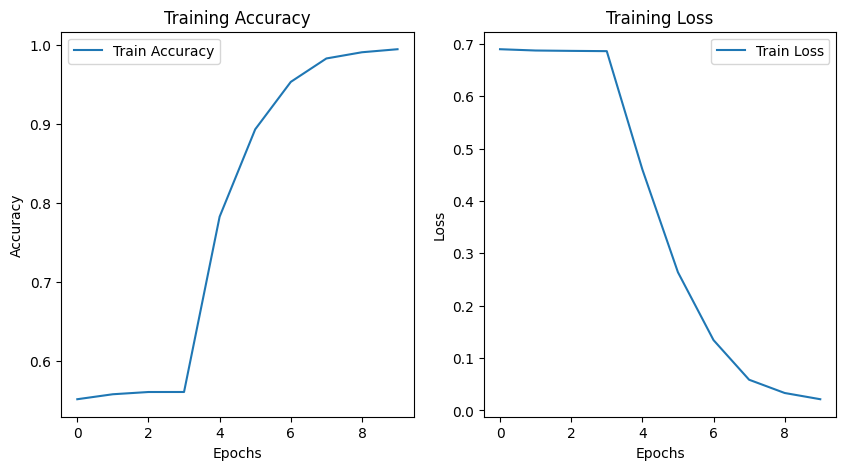

In [27]:

# After training, plot the results
plot_results(train_accuracies, train_losses)

##Calculate Evaluation Metrics

In [28]:
# Calculate metrics
precision = precision_score(labels, (np.array(preds) > 0.5).astype(int))
recall = recall_score(labels, (np.array(preds) > 0.5).astype(int))
f1 = f1_score(labels, (np.array(preds) > 0.5).astype(int))
roc_auc = roc_auc_score(labels, preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Precision: 0.8143
Recall: 0.7907
F1 Score: 0.8023
ROC AUC: 0.9022
